# Gone (randomly?) viral

### Final project in Modelling and Computational Engineering (MOD 510) Dec 2020

Lars B Lukerstuen (248800)

Joakim O Gjermundstad (251365)

# Abstract

# Introdution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scipy.optimize import curve_fit




In [3]:
class DiseaseStatus(Enum):  
    SUSCEPTIBLE = 0
    INFECTIOUS = 1
    RECOVERED = 2
    DEAD = 3

class AgeStatus(Enum):
    YOUNG = 0
    OLD = 1  
    

class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease status which is represented by an 
    integer Enum. Also, a set of integer (x, y)-coordinates are 
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a 
    walker attempts to move outside of the physical domain, nothing 
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """


    def __init__(self,population_size, no_init_infected=1,nx=50,ny=50, q=0.9):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction 
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        """
        self.N_ = population_size
        self.I0_= no_init_infected
        self.nx_= nx
        self.ny_= ny
        self.infection_probability_ = q
        self.idx_ = np.arange(0,self.N_,1)
        self.State_ = np.full(self.N_, DiseaseStatus.SUSCEPTIBLE)
        self.State_[0:self.I0_] = DiseaseStatus.INFECTIOUS
       
        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy()
        
        # Cumulative holders; accessed by the save state function
        self.infectious_cumulative =[]
        self.susceptible_cumulative =[]

        # Implementing age
        self.AgeState_ = np.full(self.N_, AgeStatus.YOUNG)
        self.AgeState_[0:int(0.5*self.N_)] = AgeStatus.OLD
        

    def is_in_invalid_position(self, walker):
        x_check = any([walker[0] > self.nx_ , walker[0] < 0])
        y_check =any([walker[1] >self.ny_ , walker[1] <0])
        return x_check or y_check

    def move_walkers(self):
        self.Walkers_Old_ = self.Walkers_.copy()
        random_step_index =np.random.randint(0,4, size =(self.N_))
        next_steps = np.array([[0,1], [1,0], [0,-1], [-1,0]])
        self.Walkers_ += next_steps[random_step_index]
       
        for walker_index in range(self.N_):
            if self.is_in_invalid_position(self.Walkers_[walker_index]):
                self.Walkers_[walker_index] = self.Walkers_Old_[walker_index] 

    def move_walkers_old_and_young(self):
        self.Walkers_Old_ = self.Walkers_.copy()
        youngcount = len(self.AgeState_[self.AgeState_==AgeStatus.YOUNG]) 
        oldagecount = len(self.AgeState_[self.AgeState_==AgeStatus.OLD]) 
        
        young_step_index =np.random.randint(0,4, size =(youngcount))
        oldage_step_index = np.random.randint(0,5, size =(oldagecount))

        next_steps = np.array([[0,1], [1,0], [0,-1], [-1,0],[0,0]])     # 1/5th of the times, [0,0] (no movement) is performed by OldAge walkers

        self.Walkers_ += next_steps[np.concatenate((oldage_step_index,young_step_index), axis =0)]
       
        for walker_index in range(self.N_):
            if self.is_in_invalid_position(self.Walkers_[walker_index]):
                self.Walkers_[walker_index] = self.Walkers_Old_[walker_index]   
    
    
    def collision(self):
        infectious_index = self.idx_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_index = self.idx_[self.State_==DiseaseStatus.SUSCEPTIBLE]
        
        infectious_locations = self.Walkers_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_location = self.Walkers_[self.State_ == DiseaseStatus.SUSCEPTIBLE]
        
        for infected_cord in infectious_locations:
            x_intersect = np.where(infected_cord[0] == susceptible_location[:,0])[0]
            y_intersect = np.where(infected_cord[1] == susceptible_location[:,1])[0]
            
            x_suscept = susceptible_index[x_intersect]
            y_suscept = susceptible_index[y_intersect]
            
            
            x_y_suscept_intersect =np.intersect1d(x_suscept,y_suscept)

            if x_y_suscept_intersect.size >0:
                for intersect in x_y_suscept_intersect:
                    #print(self.Walkers_[intersect],infected_cord)
                    if np.random.randint(0,1) < self.infection_probability_:
                        self.State_[intersect] = DiseaseStatus.INFECTIOUS
                    else:
                        pass
        
    
        
    def plot_current_state(self):     
        infectious_locations = self.Walkers_[np.where(self.State_ == DiseaseStatus.INFECTIOUS)]
        susceptible_locations = self.Walkers_[np.where(self.State_ == DiseaseStatus.SUSCEPTIBLE)]
        
        popfig, ax =plt.subplots(figsize =(10,10))
        plt.grid()
        plt.xlim(-1, self.nx_ +1)
        plt.ylim(-1, self.ny_+1)
        plt.xticks(np.arange(0,self.nx_+1,1))
        plt.yticks(np.arange(0,self.ny_+1,1))
        ax.scatter(susceptible_locations[:,0], susceptible_locations[:,1], color ='Blue', label = 'Susceptible', marker = 'v', s=80)
        ax.scatter(infectious_locations[:,0], infectious_locations[:,1], color ='Red', label = 'Infectious', marker = 'o')
        
    def save_current_state(self):
        number_of_infectious = np.count_nonzero(self.State_[self.State_ == DiseaseStatus.INFECTIOUS], axis =0)
        number_of_susceptible = np.count_nonzero(self.State_[self.State_ == DiseaseStatus.SUSCEPTIBLE], axis =0)
               
        self.infectious_cumulative.append(number_of_infectious)
        self.susceptible_cumulative.append(number_of_susceptible)
    
    def reset_model(self):
        self.State_ = np.full(self.N_, DiseaseStatus.SUSCEPTIBLE)
        self.State_[0:self.I0_] = DiseaseStatus.INFECTIOUS
        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy()

    def simulate(self, iterations):
        for i in range(iterations):
            self.save_current_state()
            self.move_walkers()
            #if i % 10 == 0:
            #     self.plot_current_state()
            self.collision()
        self.reset_model()

    def test_simulate(self, iterations):
        """ Simulation activatro for testing 
        """
        for i in range(iterations):
            self.save_current_state()
            self.move_walkers_old_and_young()
            #if i % 10 == 0:
             #    self.plot_current_state()
            self.collision()
        self.reset_model() 
        

    def infected_pop_analytic(self,t, beta):
        S0 = self.N_ -self.I0_
        I0 = self.I0_
        return np.array((S0 +I0)/(1+(S0/I0)*np.exp(-beta*t)))
            
            
        
        
        


                                             
                
                
    
        

    



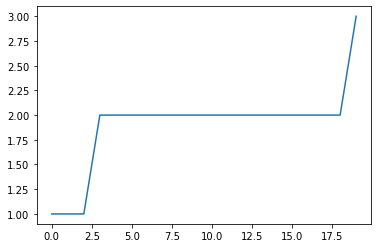

In [53]:

test_instance = RandomWalkEpidemicSimulator(population_size=5, nx =5, ny =5)

test_instance.simulate(20)



figure, axes = plt.subplots()
axes.plot(np.arange(0,len(test_instance.infectious_cumulative)),test_instance.infectious_cumulative)


# Exercise 1

### Part 1
We run the simulation 100 times,  with 1 person initially infected, a population of 682, gridsize $5\times5$ and an initial infection count of one. 

In [9]:
def simulation_runner(runs, steps=300, population_size= 682,no_init_infected=1):
    """ Function that takes in siomulation parameters and runs "runs"(number of runs) simulations
    outputs runs by steps size np.arrays of healty and sick data.
    """
    simulation_instance = RandomWalkEpidemicSimulator(population_size, no_init_infected)
    for i in range(runs):
        simulation_instance.simulate(steps)
    
    healthy_data = np.array(simulation_instance.susceptible_cumulative).reshape(runs, steps)
    sick_data = np.array(simulation_instance.infectious_cumulative).reshape(runs,steps)
   
    return healthy_data, sick_data


def simulation_plotter(healthy_data, sick_data, runs = runs, steps = steps, betaplot =0): ##Fix: runs. definere  annerledes?
    simfig, ax = plt.subplots(2,1,figsize = (15,10))

    healthy_data_lower = healthy_data.mean(axis= 0) - 0.5*healthy_data.std(axis =0)
    healthy_data_upper = healthy_data.mean(axis= 0) + 0.5*healthy_data.std(axis =0)
    
    sick_data_lower = sick_data.mean(axis= 0) - 0.5*sick_data.std(axis =0)
    sick_data_upper = sick_data.mean(axis= 0) + 0.5*sick_data.std(axis =0)
    

    ax[0].plot(np.arange(steps),healthy_data.mean(axis=0), color ='blue',label = 'Mean number of healthy individuals')
    ax[0].fill_between(np.arange(steps),healthy_data_lower,healthy_data_upper,color='lightblue' ,label ='Simulation sample-std spread' )
    ax[1].fill_between(np.arange(steps), sick_data_lower, sick_data_upper, color = 'pink', label ='Simulation sample std spread')
    ax[1].plot(np.arange(steps),sick_data.mean(axis=0), color = 'red',label ='Mean number of sick individuals')
    
    title_list=['Healthy individuals, ','Sick individuals, ']
    for i in range(2):

        ax[i].set_title(title_list[i]+ str(no_init_infected) +' initial infections, ' +str(runs) + ' simulations')
        ax[i].set_xlabel('Timestep (days)')
        ax[i].set_ylabel('Populaiton count')
        ax[i].legend()
        ax[i].grid()
    





array([<AxesSubplot:title={'center':'Healthy individuals, 1 initial infections, 1 simulations'}, xlabel='Timestep (days)', ylabel='Populaiton count'>,
       <AxesSubplot:title={'center':'Sick individuals, 1 initial infections, 1 simulations'}, xlabel='Timestep (days)', ylabel='Populaiton count'>],
      dtype=object)

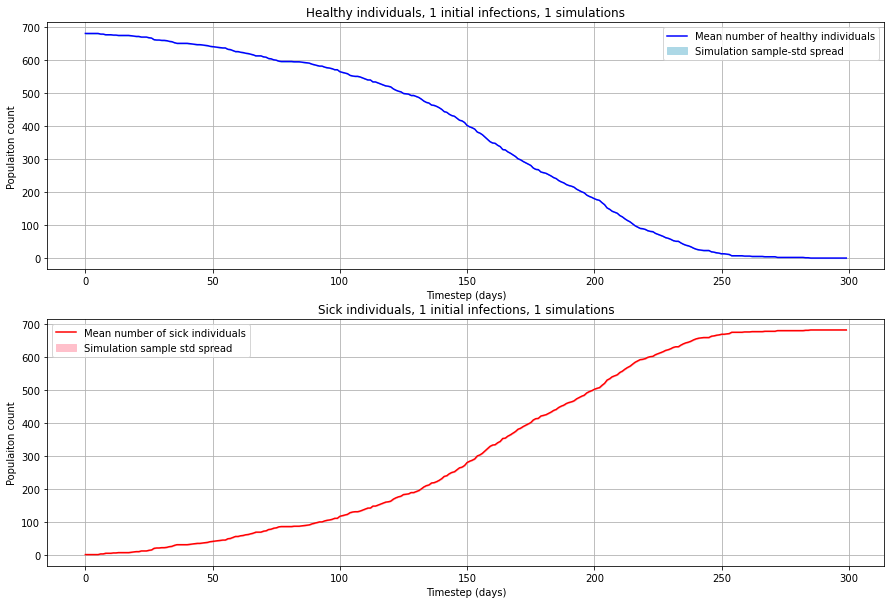

In [433]:
runs = 1
steps = 300
population_size = 682
no_init_infected = 1

#e1_healthy_data, e1_sick_data = simulation_runner(runs, steps, population_size, no_init_infected)
simulation_plotter(e1_healthy_data,e1_sick_data, runs)


# Exercise 2

### Part 1

In [15]:
###setup
runs = 100
steps = 300
population_size = 682
no_init_infected = 1

### Running simulations
# healthy_data, sick_data = simulation_runner(runs, steps, population_size, no_init_infected)
#np.savetxt('simulation_data/E1P1_sickdata',sick_data)
#np.savetxt('simulation_data/E1P1_healthydata',sick_data)

healthy_data = np.loadtxt('simulation_data/E1P1_healthydata')
sick_data =np.loadtxt('simulation_data/E1P1_sickdata')


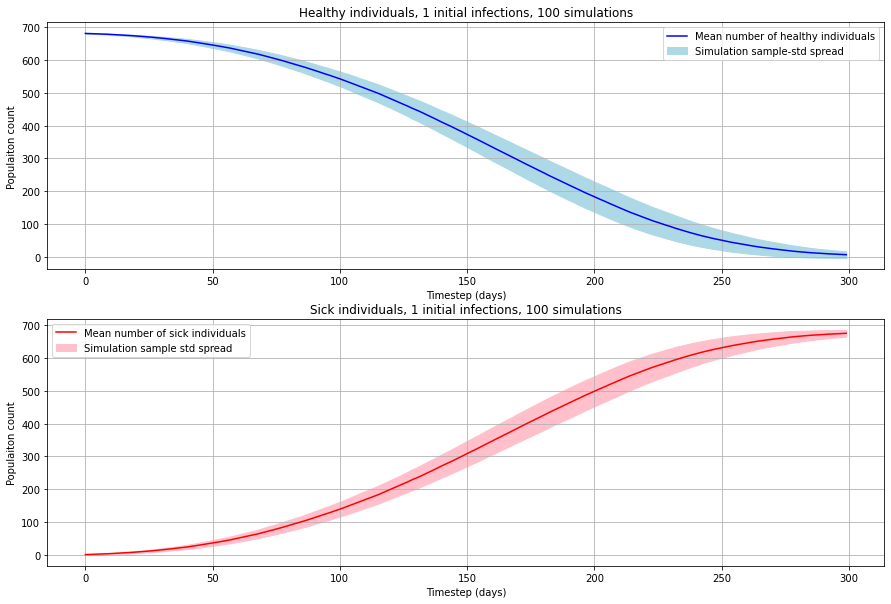

In [16]:
simulation_plotter(healthy_data,sick_data,runs)


### Part 2

In [17]:
###setup
runs = 100
steps = 300
population_size = 682
no_init_infected = 10


#p2_healthy_data, p2_sick_data = simuluation_runner(runs, steps, population_size, no_init_infected)
# np.savetxt('simulation_data/E1P2_sickdata',p2_sick_data)
# np.savetxt('simulation_data/E1P2_healthy_data',p2_healthy_data)

p2_sick_data = np.loadtxt('simulation_data/E1P2_sickdata')
p2_healthy_data = np.loadtxt('simulation_data/E1P2_healthy_data')

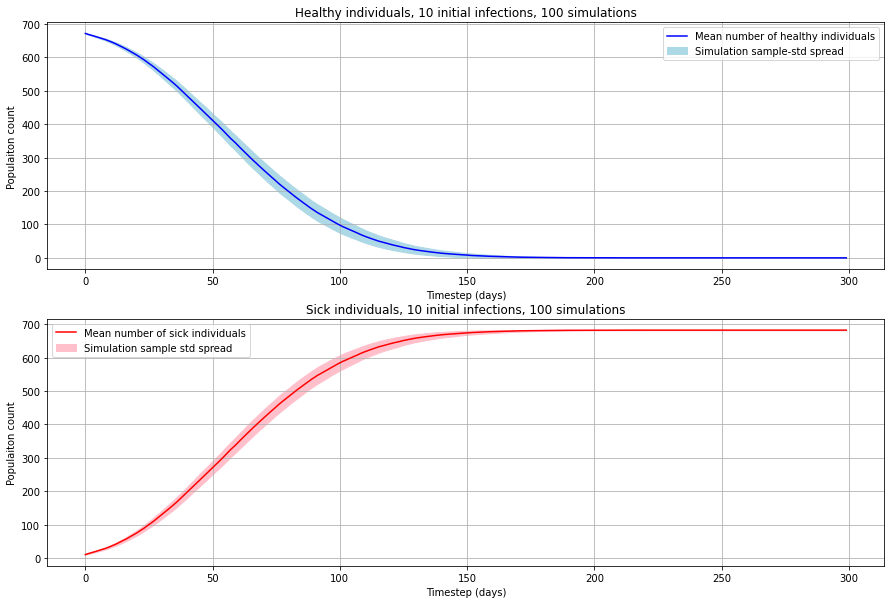

In [18]:
simulation_plotter(p2_healthy_data, p2_sick_data, runs)



We can see that in this case, the crossover point is shifted around 70 counts backwards. Our simulation is modelling a "populaiton dynamic system". E.g the rate of infections is dependent on the population of infected, hence if we start with a larger population of infected, we also start with a larger rate of infection. Additionally, we can see a decrease in sample standard deviation of the mean.

### Part 3

In this part we try to fit the analytic solution to SI model from the previous project to our simulation data. Recall that the analytic solution can be expressed as: 

$$
\begin{align}
I(t)&=\frac{N}{1+\frac{S_0}{I_0}\exp(-\beta{t})}\,,
\tag{1}
\end{align}
$$

where $\beta (t)$ is a function.

We want to find the $\beta(t)$ funciton that best describes our data. 

We make the following proposition after plotting different functions in a plotting application (geogebra): 
Suppose that $\beta(t)$ is of the following form:

\begin{equation}
\beta(t) = c e^{b_0 + b_1t+b_2t^2 ...}
\end{equation}

Yielding a infection spread function I of:
\begin{equation}
\tag{2}
I(t) = \frac{N}{1+\frac{S_0}{I_0}\exp(-{t}\cdot c \cdot e^{b_0 + b_1t+b_2t^2 ...})}
\end{equation} 

We can then define an infection spread (I(t)) in function in python taking in time step data, and having parameters $(c,b_0, b_1, b_2, ...)$ we can us scipy curve fit and fit this function over the simulation data

In [25]:
### Finding best fitting constant beta 
e1_instance_3 = RandomWalkEpidemicSimulator(population_size =682)
sickness_analytic = e1_instance_3.infected_pop_analytic

P1_fitted_beta = curve_fit(sickness_analytic, np.arange(steps),sick_data.mean(axis=0))[0]
P2_fitted_beta = curve_fit(sickness_analytic, np.arange(steps),p2_sick_data.mean(axis=0))[0]

print(P1_fitted_beta, P2_fitted_beta)

p1_analytic_const_beta = sickness_analytic(np.arange(steps), P1_fitted_beta)
p2_analytic_const_beta = sickness_analytic(np.arange(steps), P2_fitted_beta)

[0.04043209] [0.10394177]


In [26]:
### Trying out analytic solutions of I(t) with different beta functions

def infected_beta_polynomial_exponential(t, c, b0, b1, b2):
    S0 = 682-1
    I0 = 1
    beta = c*np.exp(b0 + b1*t + b2*t**2) # + b3*t**3)
    return np.array((S0 +I0)/(1+(S0/I0)*np.exp(-beta*t)))

### Fitting to simulation data  from Part 1       
p1_polyexp_fit_params = curve_fit(infected_beta_polynomial_exponential,np.arange(steps),sick_data.mean(axis=0), p0 =(0.00, 0.0, 0.0, 0.0))
print(p1_polyexp_fit_params[0])

p1_analytic_fitted_data = infected_beta_polynomial_exponential(np.arange(steps),  p1_polyexp_fit_params[0][0] , p1_polyexp_fit_params[0][1], p1_polyexp_fit_params[0][2],  p1_polyexp_fit_params[0][3])

### Fitting to simulation data  from Part 2       
p2_polyexp_fit_params = curve_fit(infected_beta_polynomial_exponential,np.arange(steps),p2_sick_data.mean(axis=0), p0 =(0.00, 0.0, 0.0, 0.0))
print(p2_polyexp_fit_params[0])

p2_analytic_fitted_data = infected_beta_polynomial_exponential(np.arange(steps),  p2_polyexp_fit_params[0][0] , p2_polyexp_fit_params[0][1], p2_polyexp_fit_params[0][2],  p2_polyexp_fit_params[0][3])


[ 5.16804337e-02  6.63207822e-01 -8.31804970e-03  1.70281109e-05]
[ 7.10147120e-02  1.41503103e+00 -2.17920222e-02  9.16346541e-05]


In [27]:
def simulation_plot_setup(simulation_data, analytic_data, analytic_const_beta):
    fig, ax = plt.subplots(figsize = (15,5))

    ###-------------------STD gettins--------------------------------------------------------
    simulation_data_lower = simulation_data.mean(axis= 0) - 0.5*simulation_data.std(axis =0)
    simulation_data_upper = simulation_data.mean(axis= 0) + 0.5*simulation_data.std(axis =0)
    
    ###
    t = np.arange(len(simulation_data[0]))

    ######-----------------------####
    ax.fill_between(t, simulation_data_lower, simulation_data_upper, color = 'pink', label ='Simulation sample std spread')
    ax.plot(t,simulation_data.mean(axis=0), color = 'red',label ='Mean number of sick individuals')
    ax.plot(t, analytic_data, label ='Analytic with fitted beta function')
    ax.plot(t, analytic_const_beta, label= 'Analytic with fitted constant beta')

    ax.set_xlabel('Timestep (days)')
    ax.set_ylabel('Populaiton count')
    ax.legend()
    ax.grid()
    return ax
    

Text(0.5, 1.0, 'Number of sick individuals, 10 initial infections 100 simulations')

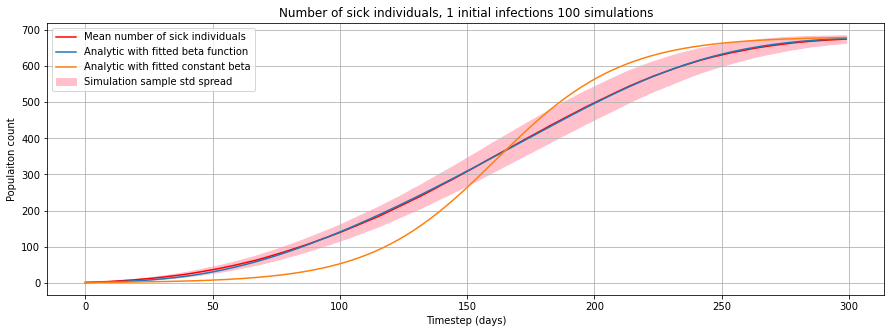

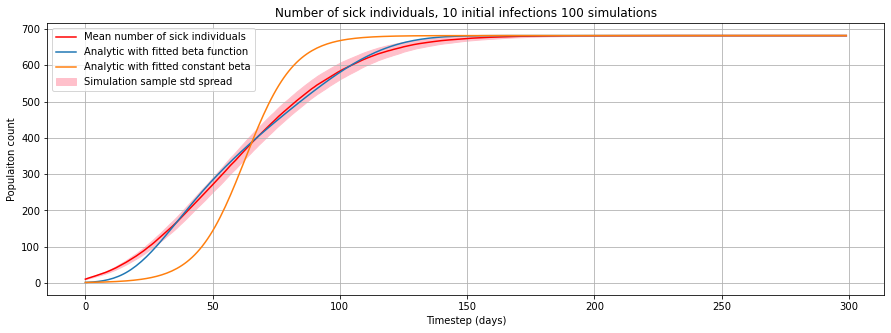

In [28]:
somefig, ax = plt.subplots(figsize=(0,0)) #Hacky?
first_plot =simulation_plot_setup(sick_data, p1_analytic_fitted_data, p1_analytic_const_beta)
first_plot.set_title('Number of sick individuals, 1 initial infections 100 simulations')
second_plot =simulation_plot_setup(p2_sick_data,p2_analytic_fitted_data, p2_analytic_const_beta)
second_plot.set_title('Number of sick individuals, 10 initial infections 100 simulations')




By fitting (2) to the simulated data, we obtained two expressions: 

$$
\begin{align}
I_1(t) \approx  \frac{N}{1+\frac{S_0}{I_0}\exp(-{t}\cdot 0.05168 \cdot e^{ 0.6632 + -.00832t+ 1.70\cdot10^{-3} t^2})}
\end{align}
$$

Hence:

$$
\begin{align}
\beta_1(t) \approx 0.05168 \cdot e^{ 0.6632 + -.00832t+ 1.70\cdot10^{-3} t^2}
\end{align}
$$

and 


$$
\begin{align}
I_2(t) \approx \frac{N}{1+\frac{S_0}{I_0}\exp(-{t}\cdot 7.101 \cdot 10^{-2} \cdot e^{ 1.415 + -2.179 \cdot 10^{-2} t + 9.163 \cdot 10^{-5} t^2})}
\end{align}
$$

with:


$$
\begin{align}
\beta_2(t) \approx 7.101 \cdot 10^{-2} \cdot e^{ 1.415 + -2.179 \cdot 10^{-2} t + 9.163 \cdot 10^{-5} t^2}
\end{align}
$$


We can see from the plots that these two functions fit the simulation data rather nicely, with the most accuracy for the data where we simulate one inital infected. 


# Exercise 3

### Part 1 

Our original \( SI \)-model was
$$
\begin{align}
\tag{3}
\frac{\mathrm{d}S(t)}{\mathrm{d}t}&=-\beta(t)\cdot\frac{S(t)I(t)}{N} \,, \\ 
\tag{4}
\frac{\mathrm{d}I(t)}{\mathrm{d}t}&=\beta(t)\cdot\frac{S(t)I(t)}{N} \,.
\end{align}
$$

In this model, $\beta(t) $was input to the model. In the random walk model we
can estimate values for $ \beta $ based on observed changes in the random
walker population. To do this, we combine equation (2)
with a first order approximation of the derivative to yield:
$$
\begin{equation}
\beta\cdot\Delta t \approx -\frac{(S(t)-S(t-\Delta t))N}{S(t)I(t)},
\tag{5}
\end{equation}
$$


Use the formula above to estimate $( \beta\cdot\Delta t )$ from your estimated numbers of healthy $( S )$, and infected $( I )$ at each time step.

In [314]:

def beta_aproximator(healthy_data, sick_data, population_size = 682): 
    """Calculating numeric gradient of healthy data, is equal to: (S(t) -(S(t+ dt))/dt, with dt =1. """
    
    dS_dt = np.gradient(healthy_data.mean(axis=0)) 

    estm_beta = -dS_dt*population_size/(healthy_data.mean(axis =0)*(sick_data.mean(axis =0)))
    estm_beta = estm_beta[np.logical_and(~np.isnan(estm_beta),~np.isinf(estm_beta))]   #Getting rid of pesky nan's and inf's
    return estm_beta

p1_estm_betas = beta_aproximator(healthy_data, sick_data)
p2_estm_betas = beta_aproximator(p2_healthy_data, p2_sick_data)

p1_mean_beta, p1_median_beta = beta_aproximator(healthy_data, sick_data).mean(),np.median(beta_aproximator(healthy_data, sick_data))
p2_mean_beta, p2_median_beta = beta_aproximator(p2_healthy_data, p2_sick_data).mean(), np.median(beta_aproximator(p2_healthy_data, p2_sick_data))           

print('Gradient estimated betas for 1 inital infecetd simulations:','mean', p1_mean_beta, 'median', p1_median_beta)
print('Gradient estimated betas for 10 inital infecetd simulations:','mean', p2_mean_beta, 'median', p2_median_beta)



Gradient estimated betas for 1 inital infecetd simulations: mean 0.03761630742122752 median 0.030216219100478402
Gradient estimated betas for 10 inital infecetd simulations: mean 0.06900633349720492 median 0.054659843078560325


222


In [308]:
def beta_3rd_degree_polynomial(t, c, b0, b1, b2):    
    return c*np.exp(b0 + b1*t + b2*t**2)


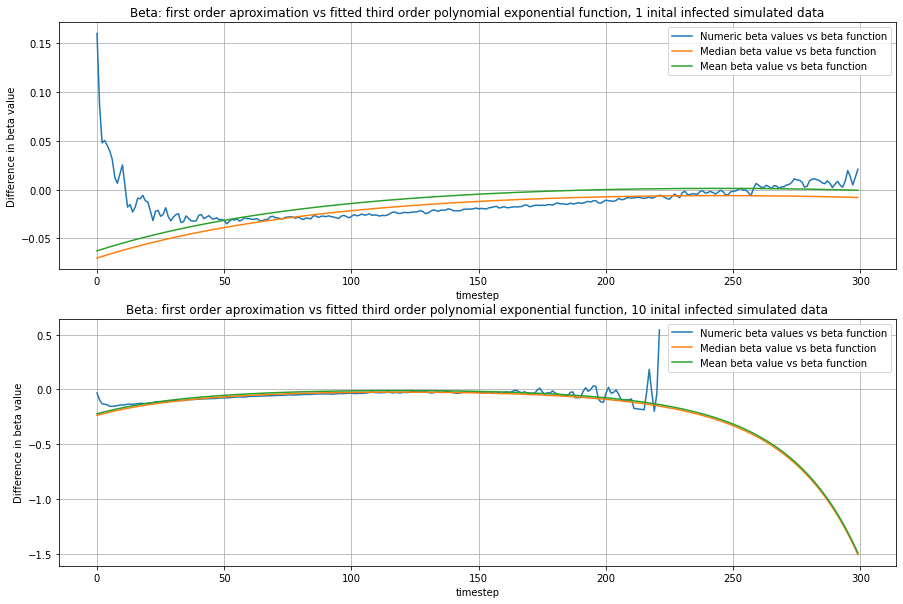

In [324]:
p1_numeric_vs_analytic = p1_estm_betas - beta_3rd_degree_polynomial(np.arange(300) ,5.16804337e-02, 6.63207822e-01,-8.31804970e-03, 1.70281109e-05)
p1_numeric_vs_analytic_median = p1_median_beta - beta_3rd_degree_polynomial(np.arange(300) ,5.16804337e-02, 6.63207822e-01,-8.31804970e-03, 1.70281109e-05)
p1_numeric_vs_analytic_mean = p1_mean_beta - beta_3rd_degree_polynomial(np.arange(300) ,5.16804337e-02, 6.63207822e-01,-8.31804970e-03, 1.70281109e-05)

p2_numeric_vs_analytic = p2_estm_betas - beta_3rd_degree_polynomial(np.arange(300),  7.10147120e-02,  1.41503103e+00, -2.17920222e-02,  9.16346541e-05)[np.arange(len(p2_estm_betas))]
p2_numeric_vs_analytic_median = p2_median_beta - beta_3rd_degree_polynomial(np.arange(300),  7.10147120e-02,  1.41503103e+00, -2.17920222e-02,  9.16346541e-05)
p2_numeric_vs_analytic_mean = p2_mean_beta - beta_3rd_degree_polynomial(np.arange(300), 7.10147120e-02,  1.41503103e+00, -2.17920222e-02,  9.16346541e-05)




t= np.arange(300)
shouldbezerofig, zeroax = plt.subplots(2,1, figsize = (15,10))
zeroax[0].plot(t, p1_numeric_vs_analytic, label = 'Numeric beta values vs beta function')
zeroax[0].plot(t, p1_numeric_vs_analytic_median, label = 'Median beta value vs beta function')
zeroax[0].plot(t, p1_numeric_vs_analytic_mean,label = 'Mean beta value vs beta function')
zeroax[1].plot(np.arange(len(p2_estm_betas)), p2_numeric_vs_analytic,label = 'Numeric beta values vs beta function')
zeroax[1].plot(t,p2_numeric_vs_analytic_median, label = 'Median beta value vs beta function')
zeroax[1].plot(t,p2_numeric_vs_analytic_mean,label = 'Mean beta value vs beta function')
zeroax[0].set_title('Beta: first order aproximation vs fitted third order polynomial exponential function, 1 inital infected simulated data')
zeroax[1].set_title('Beta: first order aproximation vs fitted third order polynomial exponential function, 10 inital infected simulated data')
for i in (0,1):
    zeroax[i].set_xlabel('timestep')
    zeroax[i].set_ylabel('Difference in beta value')
    zeroax[i].legend()
    zeroax[i].grid()


Here in the last plot, we compare the difference between the singular mean and median value for the first order approximation of the beta value, and the beta value function that we obtained from exercise 2. First of we must note that our numeric beta value is unstable around the points where the denominator of equation (5) is close to zero. However, when comparing the mean and median values to the fitted beta function, we can see that we get somewhat close to the actual value where the mean beta over 1 intial infected data perfroms the best with a maximum error of around 0.08 at timestep 0. 
We shoould also note that we can compare the average and median beta values with the fitted curve where we consider the beta function to be a constant. From this we calculated respective beta values of [0.04043209] for 1 intial infected and [0.10394177] for 10. For the 1 intial infection simulation mean and median numerically calulated beta was: [mean 0.0376, median 0.0302]
while for 10 intial infected we had numeric betas of: [mean 0.069,median 0.0547]

### Part 2

In [18]:
def old_young_simulation_runner(runs, steps=300, population_size= 682,no_init_infected=1):
    """ Function that takes in siomulation parameters and runs "runs"(number of runs) simulations
    outputs runs by steps size np.arrays of healty and sick data.
    """
    simulation_instance = RandomWalkEpidemicSimulator(population_size, no_init_infected)
    for i in range(runs):
        simulation_instance.test_simulate(steps)
    
    healthy_data = np.array(simulation_instance.susceptible_cumulative).reshape(runs, steps)
    sick_data = np.array(simulation_instance.infectious_cumulative).reshape(runs,steps)
   
    return healthy_data, sick_data



In [20]:
###setup
runs = 100
steps = 300
population_size = 682
no_init_infected = 1

#OldandYoungHealthydata,OldandYoungSickData = old_young_simulation_runner(runs, steps, population_size, no_init_infected)

#np.savetxt('simulation_data/OldandYoungHealthy_data',OldandYoungHealthydata)
#np.savetxt('simulation_data/OldandYoungSick_data',OldandYoungSickData)

OldandYoungHealthydata= np.loadtxt('simulation_data/OldandYoungHealthy_Data')
OldandYoungSickData = np.loadtxt('simulation_data/OldandYoungSick_Data')


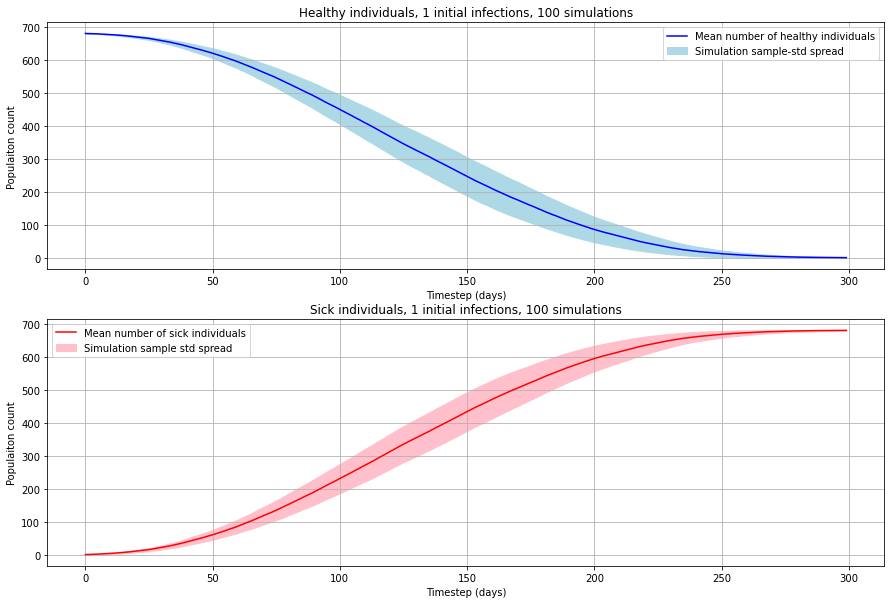

In [12]:
simulation_plotter(OldandYoungHealthydata, OldandYoungSickData)

In [49]:
### Calculating beta: 

#constant beta:
rw_instace = RandomWalkEpidemicSimulator(682)
young_old_analytic = rw_instace.infected_pop_analytic

OY_Oneinitial_constBeta= curve_fit(young_old_analytic, np.arange(steps),OldandYoungSickData.mean(axis=0))[0]
OldYoung_OneInitial_fitted_const_beta_data = young_old_analytic(np.arange(steps), OY_Oneinitial_constBeta)

#Polynomial exponent beta function: 
OldYoung_polyexp_fit_params = curve_fit(infected_beta_polynomial_exponential,np.arange(steps),OldandYoungSickData.mean(axis=0), p0 =(0.00, 0.0, 0.0, 0.0))
print(OldYoung_polyexp_fit_params[0])

OldYoung_OneInital_annalytic_fitted_data = infected_beta_polynomial_exponential(np.arange(steps),OldYoung_polyexp_fit_params[0][0],OldYoung_polyexp_fit_params[0][1],OldYoung_polyexp_fit_params[0][2], OldYoung_polyexp_fit_params[0][3])



[ 5.79358581e-02  7.91101238e-01 -9.99676022e-03  2.23483729e-05]


Text(0.5, 1.0, 'One intial infected plot without age model')

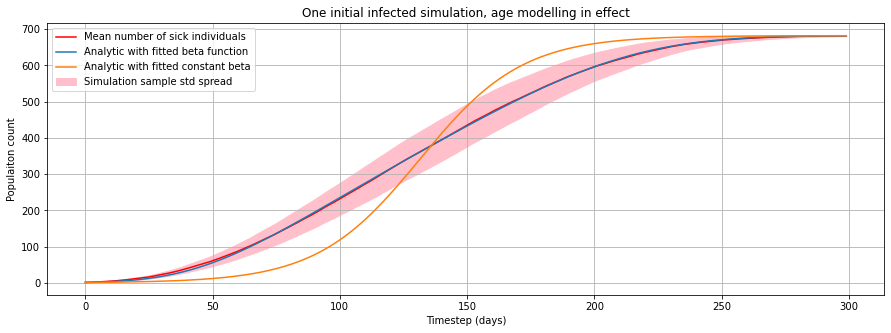

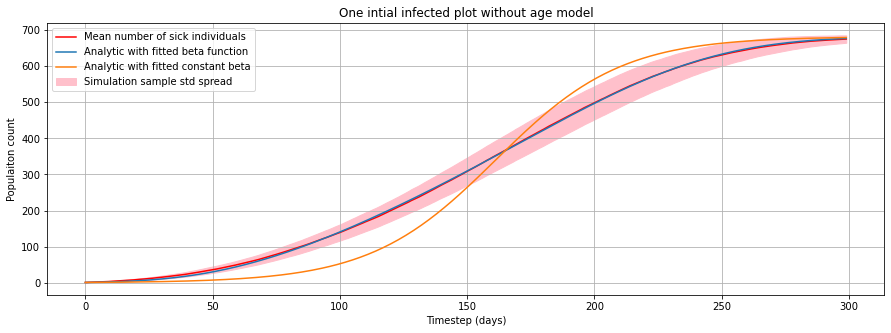

In [52]:
OYfig, oyax = plt.subplots(figsize=(0,0))
Oy_one_initial_p= simulation_plot_setup(OldandYoungSickData,OldYoung_OneInital_annalytic_fitted_data, OldYoung_OneInitial_fitted_const_beta_data)
Oy_one_initial_p.set_title('One initial infected simulation, age modelling in effect')
previous_plot =simulation_plot_setup(sick_data, p1_analytic_fitted_data, p1_analytic_const_beta)
previous_plot.set_title('One intial infected plot without age model')



Surprisingly we can see that when we implement the age model, the infection actually spreads faster, with a larger spread. We have a suggestion for why this efefct might be: We have modelled half the populaiton to have 20% less likelihood to move at a given timestep. This means that the instances of the population that are in the young age group is constantly moving while the instances in the old age group moves 80 percent of the time. Suppose the old age group stood completely still: If one would then consider a young individual to moving from one vertex to another, is it more likely to land on an "occupied" vertex if some part of the population was rigidly planted on the grid. E.g we postulate that collision are more likely when half of the population is non moving and this will increase the disease spread. 

# Exercise 4